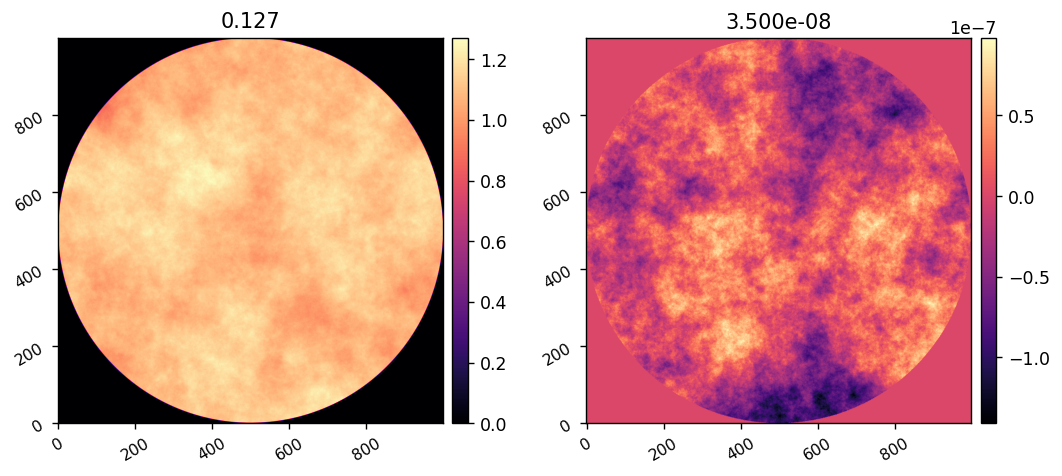

In [1]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

In [4]:
type(xp.array([0]))

cupy.ndarray

In [5]:
poppy.xp

<module 'cupy' from '/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/cupy/__init__.py'>

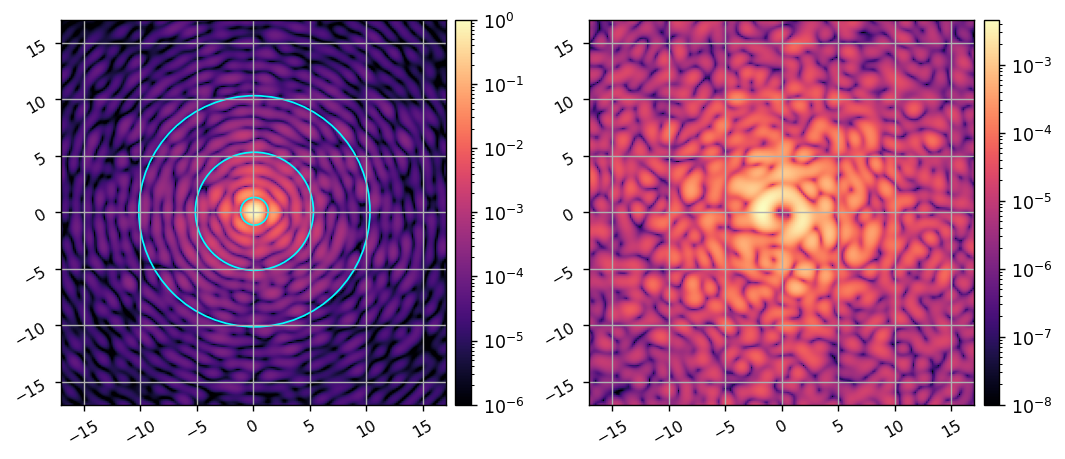

In [2]:
reload(cscoob)
reload(scoobpsf.dm)
model = cscoob.CORO()
model.WFE = WFE
ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True

im0 = model.snap()

imshow2(ref_psf/model.Imax_ref, im0, lognorm=True, vmin1=1e-6, vmin2=1e-8,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+4, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+9, fill=False, color='cyan')])

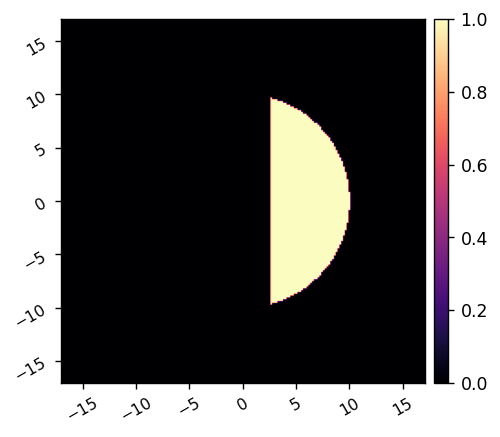

In [4]:
reload(lina.utils)
iwa = 2.5
owa = 10
edge = 2.5
control_mask = lina.utils.create_annular_focal_plane_mask(model, iwa, owa, edge=edge, shift=(0,0), rotation=0)
imshow1(control_mask, pxscl=model.psf_pixelscale_lamD)

In [7]:
model.lyot_pupil_diam, model.dm_pupil_diam

(<Quantity 9.4 mm>, <Quantity 9.4 mm>)

In [8]:
9.4/10.2 * 8.6/9.4

(0.8431372549019608, 0.9148936170212765)

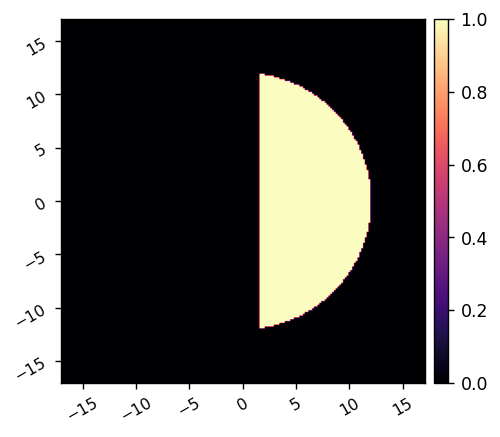

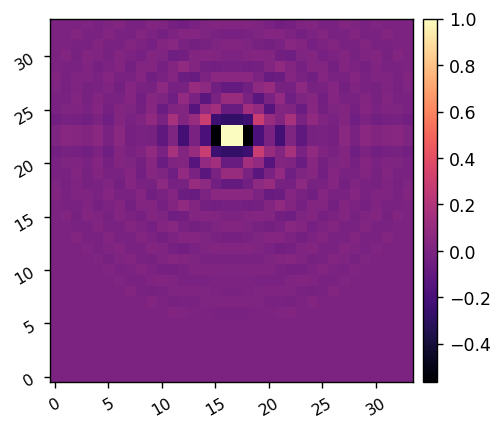

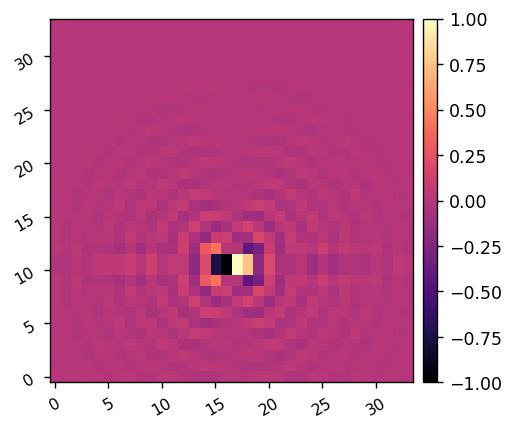

In [35]:
reload(lina.utils)
probe_amp = 5e-9

reload(lina.utils)
probe_iwa = 1.5
probe_owa = 12
probe_edge = 1.5
probe_mask = lina.utils.create_annular_focal_plane_mask(model, probe_iwa, probe_owa, edge=probe_edge, shift=(0,0), rotation=0)
imshow1(probe_mask, pxscl=model.psf_pixelscale_lamD)
probe_modes = lina.utils.create_fourier_probes(model, probe_mask, fourier_sampling=0.25, 
                                               shift=[(0,6), (0,-6)], 
                                             #   shift=[(-8,8), (8,-8)], 
                                               use_weighting=True,
                                               nprobes=2, 
                                               plot=True, )

# probe_modes = lina.utils.create_random_probes(probe_amp, 1, ensure_np_array(model.dm_mask), fmin=1, fmax=12, nprobes=3, 
#                                              #  plot=True,
#                                              )
# probe_modes = xp.array(probe_modes)/2
# imshow2(probe_modes[0], probe_modes[1])

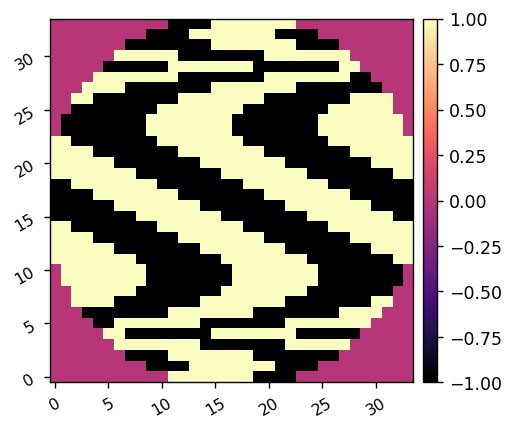

In [36]:
reload(lina.utils)

calib_amp = 5e-9
calib_modes = lina.utils.create_hadamard_modes(model.dm_mask)
imshow1(calib_modes[8].reshape(model.Nact, model.Nact))

404

202

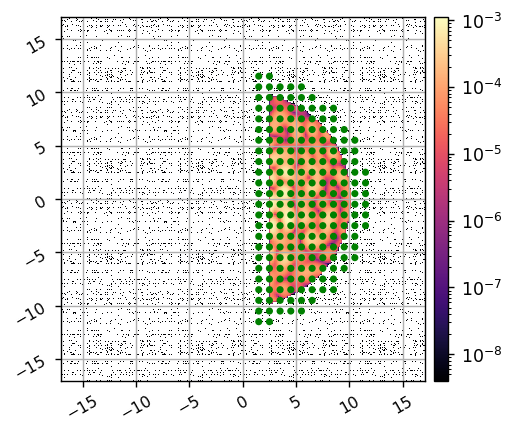

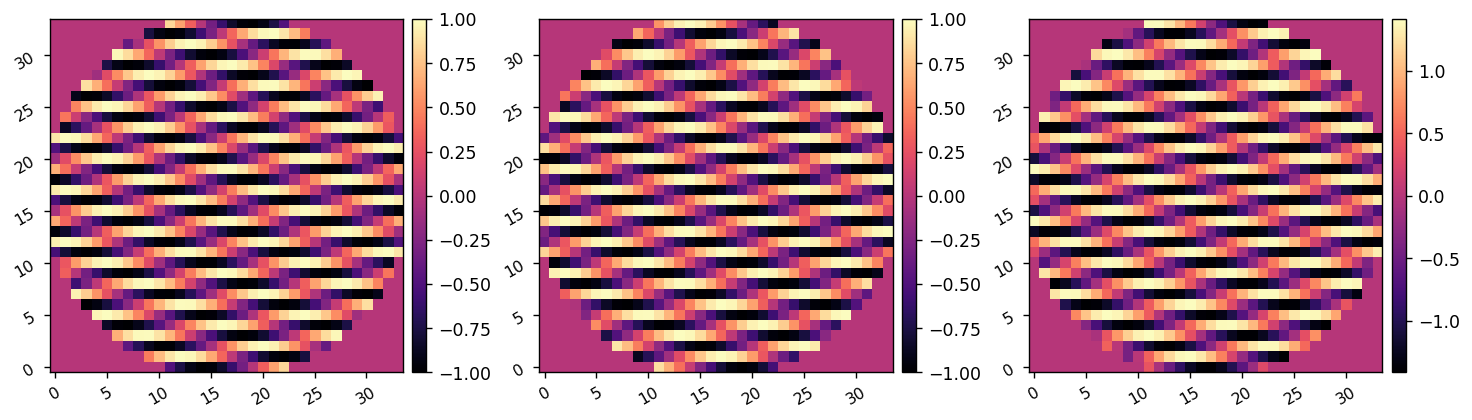

In [29]:
reload(lina.utils)

calib_amp = 5e-9

calib_mask = lina.utils.create_annular_focal_plane_mask(model, probe_iwa, probe_owa, edge=probe_edge, rotation=0)
calib_modes, fs = lina.utils.create_fourier_modes(model, calib_mask, fourier_sampling=1, return_fs=True) 
calib_modes = xp.array(calib_modes)
nmodes = calib_modes.shape[0]
nf = nmodes//2
display(nmodes, nf)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
imshow1(im0*control_mask, lognorm=True, pxscl=model.psf_pixelscale_lamD, patches=patches, grid=True)
cos = calib_modes[0].reshape(model.Nact,model.Nact)
sin = calib_modes[0+nf].reshape(model.Nact,model.Nact)
imshow3(cos, sin, cos+sin)



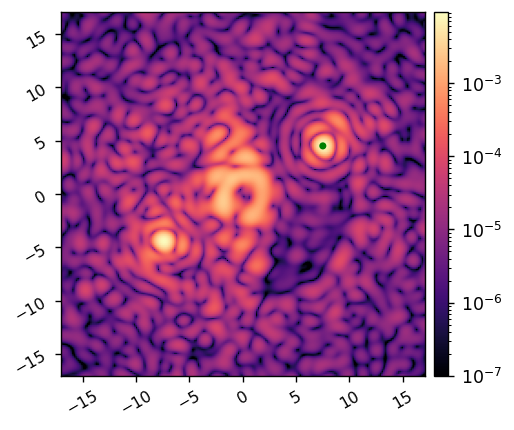

In [30]:
i = 150
cos = 10e-9*calib_modes[i].reshape(model.Nact,model.Nact)
model.add_dm(cos)
cos_im = model.snap()
model.add_dm(-cos)

imshow1(cos_im, pxscl=model.psf_pixelscale_lamD, 
lognorm=True, vmin=1e-7, patches=[Circle((fs[i][0], fs[i][1]), 0.25, fill=True, color='g')])

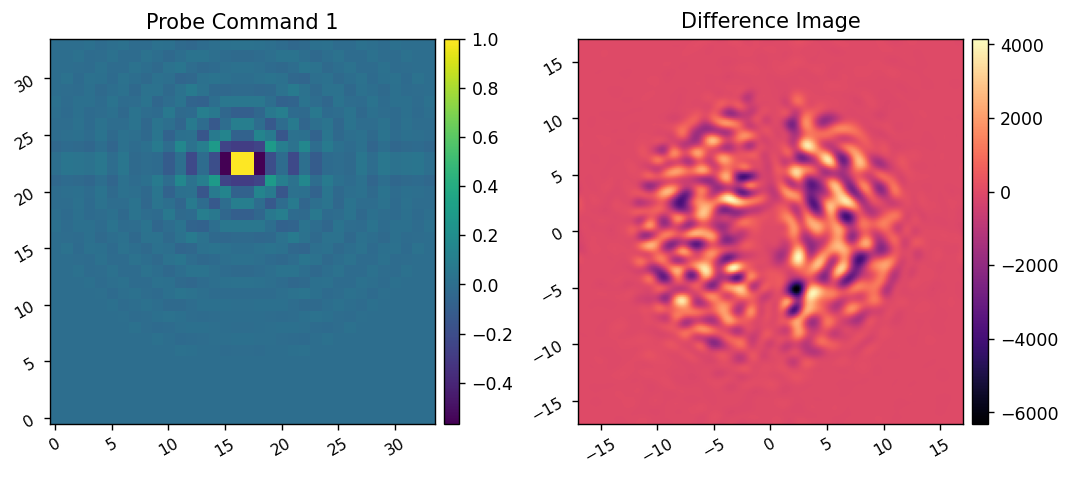

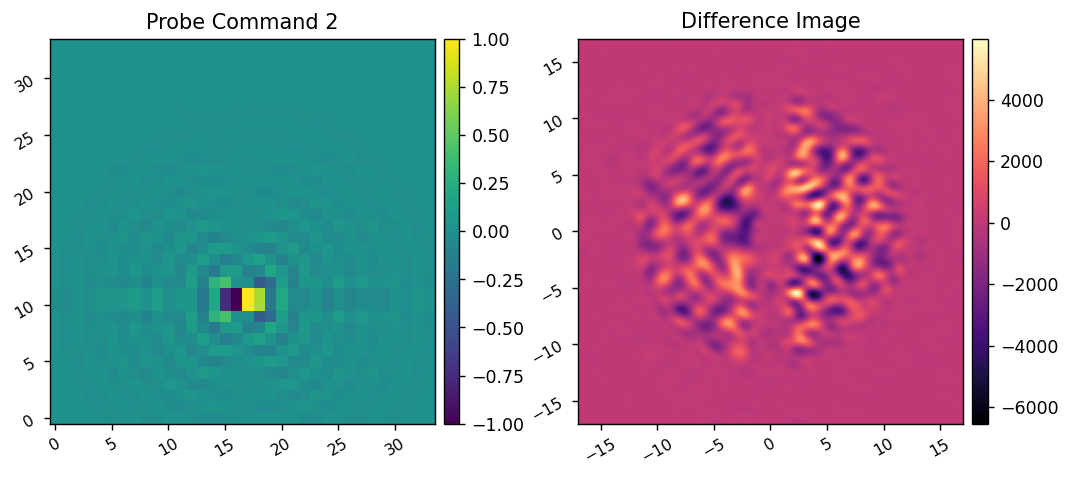

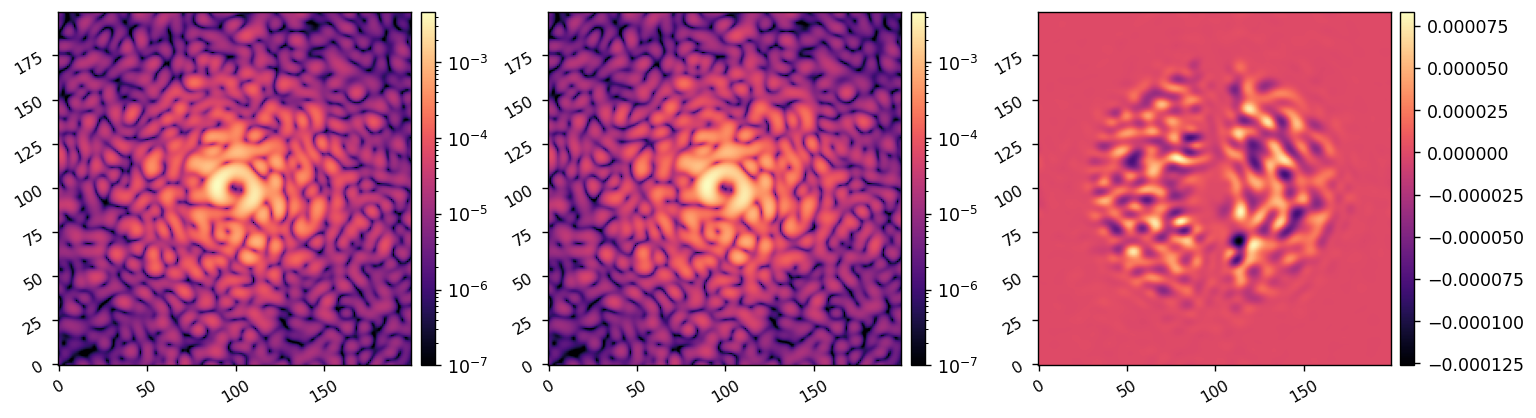

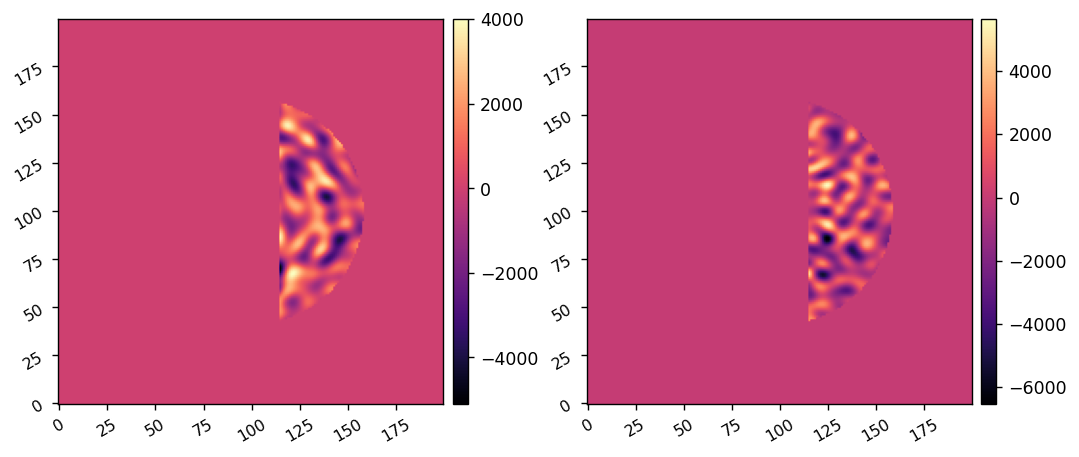

In [37]:
reload(lina.iefc)
model.reset_dm()

probe_amp = 10e-9
differential_images, ims  = lina.iefc.take_measurement(model, xp.array(probe_modes), probe_amp, plot=True, return_all=True)
imshow3(ims[0].reshape(model.npsf,model.npsf), ims[1].reshape(model.npsf,model.npsf), 
        ims[1].reshape(model.npsf,model.npsf)-ims[0].reshape(model.npsf,model.npsf), 
        lognorm1=True, lognorm2=True, vmin1=1e-7, vmin2=1e-7)
imshow2(differential_images[0].reshape(model.npsf, model.npsf)*control_mask, 
        differential_images[1].reshape(model.npsf, model.npsf)*control_mask)


In [38]:
reload(lina.iefc)
model.reset_dm()

probe_amp = 5e-9
calib_amp = 5e-9

response_matrix, response_cube = lina.iefc.calibrate(model, 
                                                     control_mask, 
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes, 
                                                     return_all=True)

Calibrating iEFC...
	Calibrated mode 1/1024 in 0.275s
	Calibrated mode 2/1024 in 0.550s
	Calibrated mode 3/1024 in 0.826s
	Calibrated mode 4/1024 in 1.100s
	Calibrated mode 5/1024 in 1.375s
	Calibrated mode 6/1024 in 1.650s
	Calibrated mode 7/1024 in 1.925s
	Calibrated mode 8/1024 in 2.200s
	Calibrated mode 9/1024 in 2.475s
	Calibrated mode 10/1024 in 2.749s
	Calibrated mode 11/1024 in 3.025s
	Calibrated mode 12/1024 in 3.300s
	Calibrated mode 13/1024 in 3.575s
	Calibrated mode 14/1024 in 3.851s
	Calibrated mode 15/1024 in 4.125s
	Calibrated mode 16/1024 in 4.400s
	Calibrated mode 17/1024 in 4.675s
	Calibrated mode 18/1024 in 4.950s
	Calibrated mode 19/1024 in 5.225s
	Calibrated mode 20/1024 in 5.500s
	Calibrated mode 21/1024 in 5.775s
	Calibrated mode 22/1024 in 6.050s
	Calibrated mode 23/1024 in 6.325s
	Calibrated mode 24/1024 in 6.601s
	Calibrated mode 25/1024 in 6.876s
	Calibrated mode 26/1024 in 7.151s
	Calibrated mode 27/1024 in 7.427s
	Calibrated mode 28/1024 in 7.702s
	Calibrat

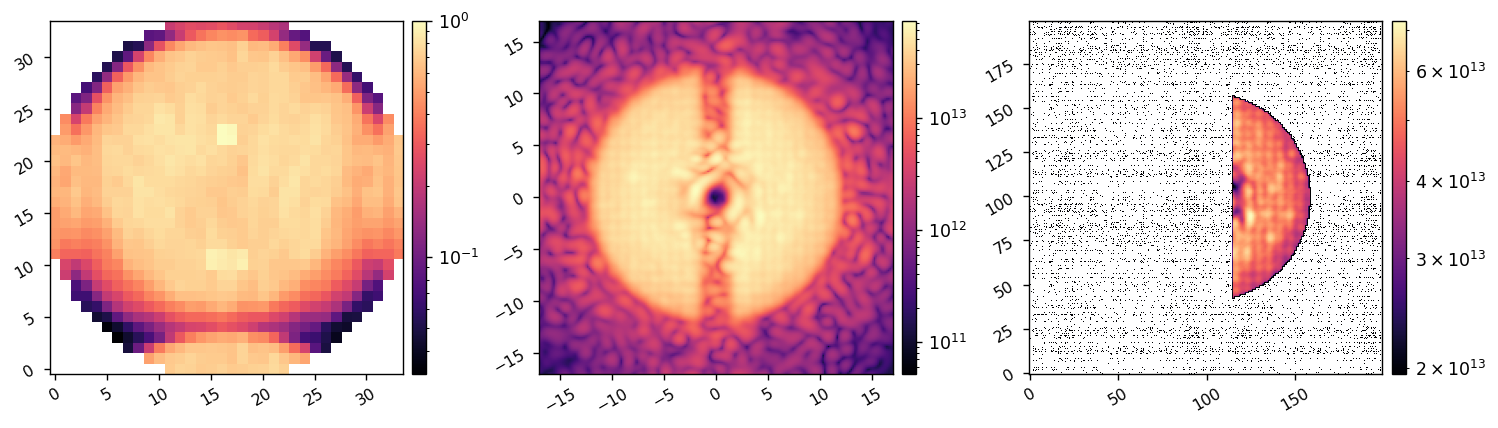

In [34]:
rms_responses = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes)), axis=0)).reshape(model.Nact, model.Nact)
rms_responses /= xp.max(rms_responses)
fp_response = xp.sum(abs(response_cube), axis=(0,1)).reshape(model.npsf,model.npsf)
imshow3(rms_responses, fp_response, control_mask*fp_response, lognorm=True, pxscl2=model.psf_pixelscale_lamD)

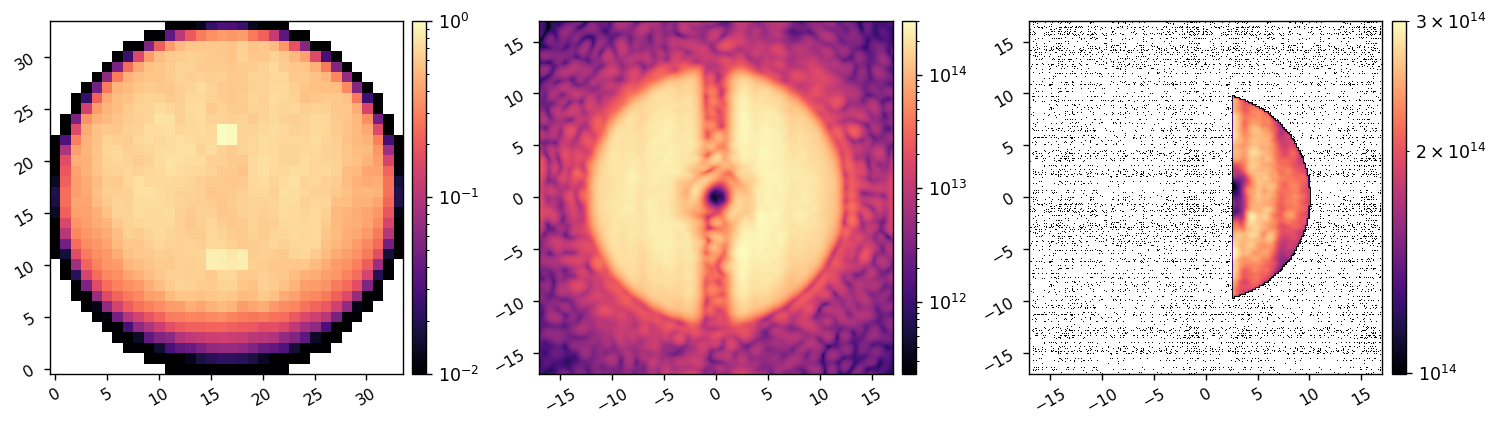

In [48]:
rms_responses = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes)), axis=0)).reshape(model.Nact, model.Nact)
rms_responses /= xp.max(rms_responses)
fp_response = xp.sum(abs(response_cube), axis=(0,1)).reshape(model.npsf,model.npsf)
imshow3(rms_responses, fp_response, control_mask*fp_response, lognorm=True, vmin1=1e-2, 
        pxscl2=model.psf_pixelscale_lamD, pxscl3=model.psf_pixelscale_lamD)

In [40]:
model.scc_mode

False

In [41]:
model.reset_dm()

dm_commands = xp.array([model.get_dm()])
images = xp.array([im0])

Running iEFC...
	Closed-loop iteration 16 / 18


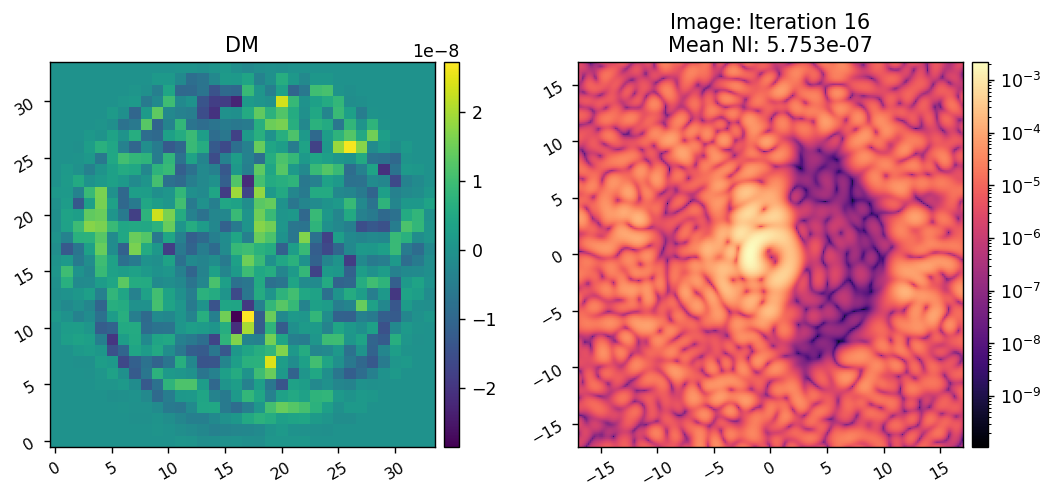

	Closed-loop iteration 17 / 18


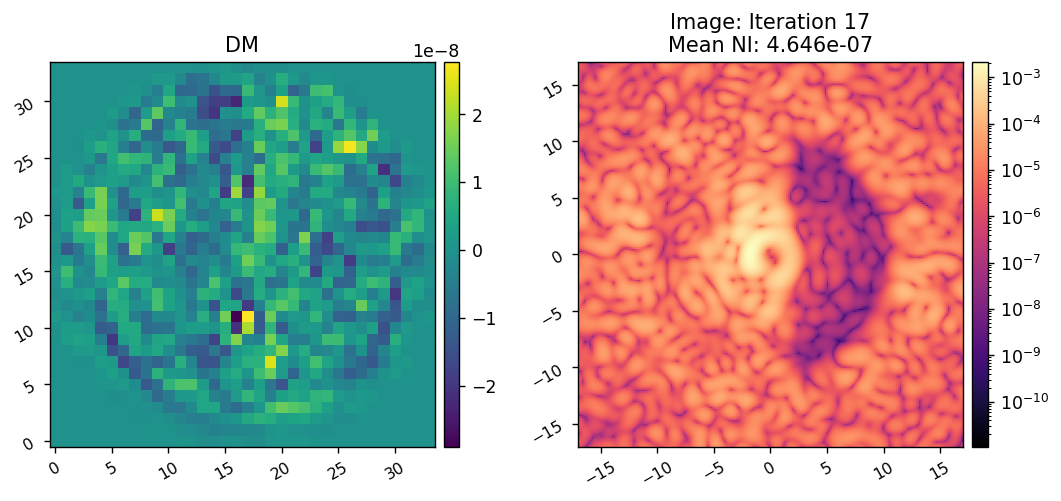

	Closed-loop iteration 18 / 18


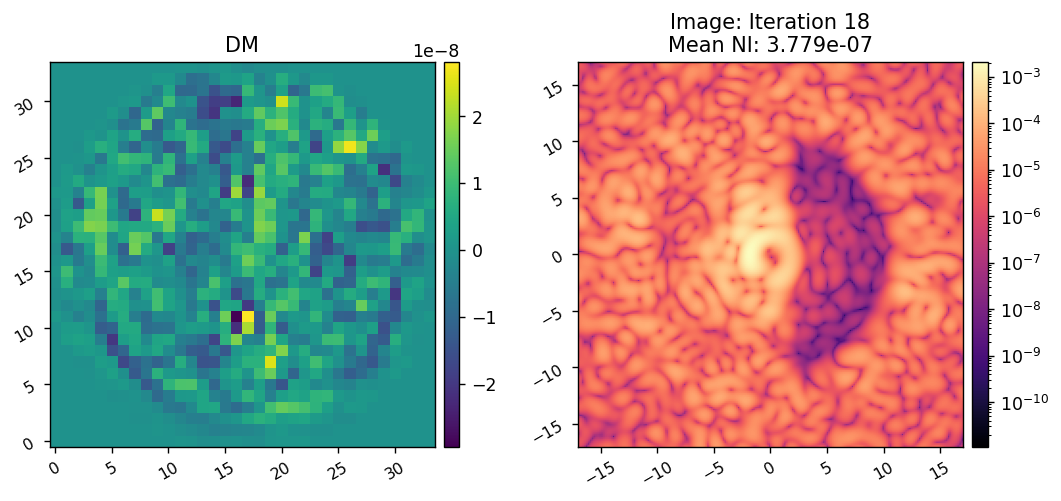

In [47]:
reload(lina.iefc)
reload(lina.utils)

probe_amp = 5e-9
probe_amp = 2.5e-9
probe_amp = 1e-9
# probe_amp = 1e-9/10

reg_cond = -2
reg_cond = -3
# reg_cond = -5

control_matrix = lina.utils.beta_reg(response_matrix, beta=reg_cond)

images, dm_commands = lina.iefc.run(model, 
                              control_matrix,
                              probe_modes, 
                              probe_amp, 
                              calib_modes,
                              control_mask, 
                              num_iterations=3, 
                              loop_gain=0.25, 
                              leakage=0.0,
                              plot_all=True,
                              old_images=images, 
                              old_dm_commands=dm_commands
                             )